# Random Forest Model - Comparison Analysis

This notebook demonstrates **scikit-learn's Random Forest** on the same dataset used for our custom Logistic Regression.

**Purpose:** Compare ensemble tree-based methods with linear classification

**Key Differences:**
- **Random Forest:** Ensemble of decision trees, captures non-linear patterns
- **Logistic Regression:** Linear decision boundary, interpretable coefficients

**Dataset:** Same Adult Income Dataset with identical train/validation split

In [42]:
import sys
sys.path.append('../src')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

from preprocess import build_preprocessor

plt.style.use('default')
sns.set_palette("husl")

## 1. Load and preprocess data

Using the same pre-split data for fair comparison with Logistic Regression.

In [43]:
# Load pre-split data
train_df = pd.read_csv('../data/train_split.csv')
val_df = pd.read_csv('../data/val_split.csv')

X_train = train_df.drop(columns=["income_>50K"])
y_train = train_df["income_>50K"]

X_val = val_df.drop(columns=["income_>50K"])
y_val = val_df["income_>50K"]

# Try to load trained Random Forest model
try:
    from utils import load_model
    rf_model = load_model(filename="random_forest_model.pkl")
    
    # Extract components
    preprocessor = rf_model.named_steps['preprocess']
    rf_classifier = rf_model.named_steps['rf']
    
    # Make predictions
    X_val_processed = preprocessor.transform(X_val)
    y_pred = rf_classifier.predict(X_val_processed)
    y_pred_proba = rf_classifier.predict_proba(X_val_processed)[:, 1]
    
    print(f"Training samples: {len(X_train)}")
    print(f"Validation samples: {len(X_val)}")
    print(f"Feature dimensions: {X_val_processed.shape[1]}")
    print(f"Number of trees: {rf_classifier.n_estimators}")
    print("✓ Random Forest model loaded successfully!")
    
except FileNotFoundError:
    print("=" * 70)
    print("⚠️  RANDOM FOREST MODEL NOT FOUND")
    print("=" * 70)
    print("You need to train the Random Forest model first!")
    print("\nSteps to train:")
    print("  1. Open a terminal")
    print("  2. Run: cd /home/javkhlan/Statistics/src")
    print("  3. Run: python train_random_forest.py")
    print("  4. Wait for training to complete (~1-2 minutes)")
    print("  5. Come back and re-run this notebook")
    print("\nThe training script will:")
    print("  - Use the same train/val split as logistic regression")
    print("  - Train a 200-tree Random Forest with optimized hyperparameters")
    print("  - Handle class imbalance with balanced weights")
    print("  - Save the model to models/random_forest_model.pkl")
    print("=" * 70)
    raise

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s


Training samples: 35165
Validation samples: 8792
Feature dimensions: 107
Number of trees: 200
✓ Random Forest model loaded successfully!


[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 200 out of 200 | elapsed:    0.1s finished


In [44]:
# Model is already trained and loaded above
# This cell is kept for reference to show the hyperparameters used

print("Random Forest hyperparameters:")
print(f"  n_estimators: {rf_classifier.n_estimators}")
print(f"  max_depth: {rf_classifier.max_depth}")
print(f"  min_samples_split: {rf_classifier.min_samples_split}")
print(f"  min_samples_leaf: {rf_classifier.min_samples_leaf}")
print(f"  max_features: {rf_classifier.max_features}")
print(f"  class_weight: {rf_classifier.class_weight}")

Random Forest hyperparameters:
  n_estimators: 200
  max_depth: 25
  min_samples_split: 15
  min_samples_leaf: 5
  max_features: sqrt
  class_weight: balanced


## 3. Model performance metrics

In [45]:
# Calculate metrics
metrics = {
    "Accuracy": accuracy_score(y_val, y_pred),
    "Precision": precision_score(y_val, y_pred),
    "Recall": recall_score(y_val, y_pred),
    "F1 Score": f1_score(y_val, y_pred)
}

# Display metrics
metrics_df = pd.DataFrame(list(metrics.items()), columns=['Metric', 'Score'])
metrics_df

,Metric,Score
0,Accuracy,0.813581
1,Precision,0.573646
2,Recall,0.860741
3,F1 Score,0.688462


## 4. Confusion matrix

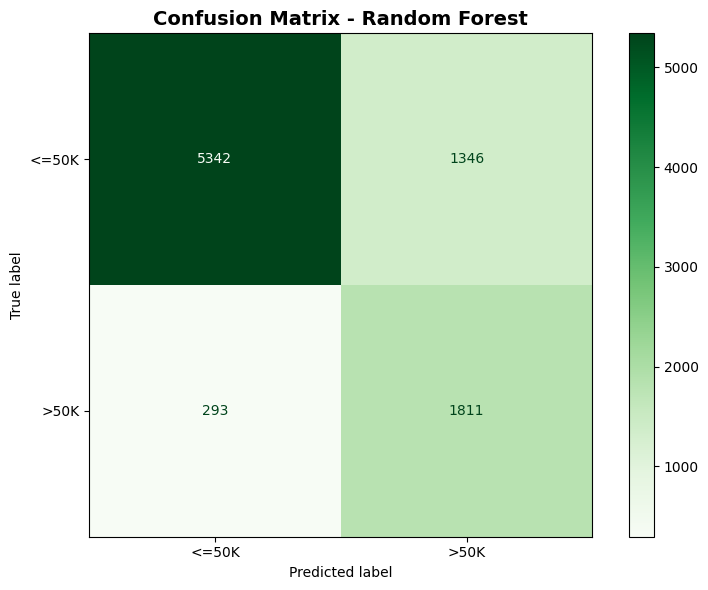


True negatives:   5342
False positives:  1346
False negatives:   293
True positives:   1811


In [46]:
cm = confusion_matrix(y_val, y_pred)

fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['<=50K', '>50K'])
disp.plot(ax=ax, cmap='Greens', values_format='d')
plt.title('Confusion Matrix - Random Forest', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\nTrue negatives:  {cm[0][0]:5d}")
print(f"False positives: {cm[0][1]:5d}")
print(f"False negatives: {cm[1][0]:5d}")
print(f"True positives:  {cm[1][1]:5d}")

## 5. Classification report

In [47]:
print(classification_report(y_val, y_pred, target_names=['<=50K', '>50K']))

              precision    recall  f1-score   support

       <=50K       0.95      0.80      0.87      6688
        >50K       0.57      0.86      0.69      2104

    accuracy                           0.81      8792
   macro avg       0.76      0.83      0.78      8792
weighted avg       0.86      0.81      0.82      8792



## 6. Feature importance

Random Forest provides feature importance based on how much each feature reduces impurity across all trees.

In [48]:
# Get feature names
feature_names = []
numeric_features = preprocessor.transformers_[0][2]
feature_names.extend(numeric_features)

cat_encoder = preprocessor.transformers_[1][1].named_steps['encoder']
cat_feature_names = cat_encoder.get_feature_names_out(preprocessor.transformers_[1][2])
feature_names.extend(cat_feature_names)

# Get feature importances from the classifier inside the pipeline
importances = rf_classifier.feature_importances_

# Create dataframe
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values('Importance', ascending=False)

print("Top 20 most important features:")
print(importance_df.head(20).to_string(index=False))

Top 20 most important features:
                          Feature  Importance
marital-status_Married-civ-spouse    0.160773
                  educational-num    0.105879
             relationship_Husband    0.100748
                              age    0.095513
                     capital-gain    0.086627
     marital-status_Never-married    0.057881
                   hours-per-week    0.051547
           relationship_Own-child    0.029989
       relationship_Not-in-family    0.024592
                relationship_Wife    0.024255
                      gender_Male    0.022137
                     capital-loss    0.021060
                    gender_Female    0.018321
       occupation_Exec-managerial    0.017759
        occupation_Prof-specialty    0.017216
          marital-status_Divorced    0.014505
              education_Bachelors    0.014185
         occupation_Other-service    0.013998
                education_HS-grad    0.011816
           relationship_Unmarried    0.010853


## 7. Feature importance visualization

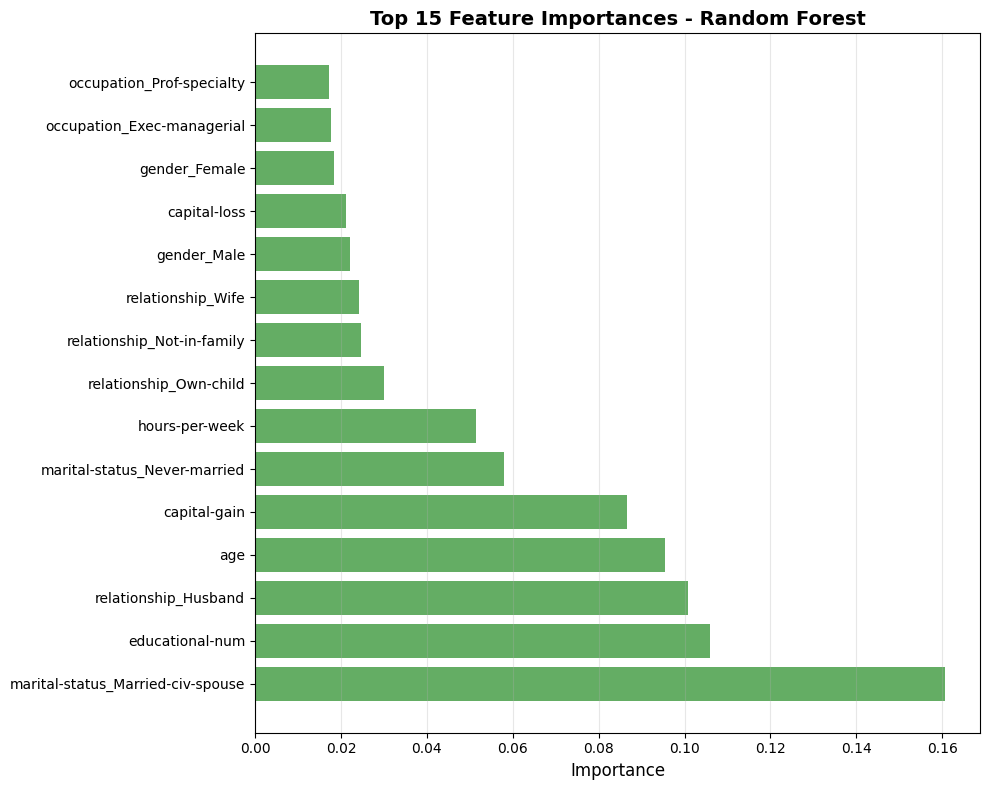

In [49]:
# Plot top 15 features
top_n = 15
top_features = importance_df.head(top_n)

fig, ax = plt.subplots(figsize=(10, 8))
ax.barh(range(len(top_features)), top_features['Importance'], color='forestgreen', alpha=0.7)
ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features['Feature'])
ax.set_xlabel('Importance', fontsize=12)
ax.set_title(f'Top {top_n} Feature Importances - Random Forest', fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

## 8. Prediction probability distribution

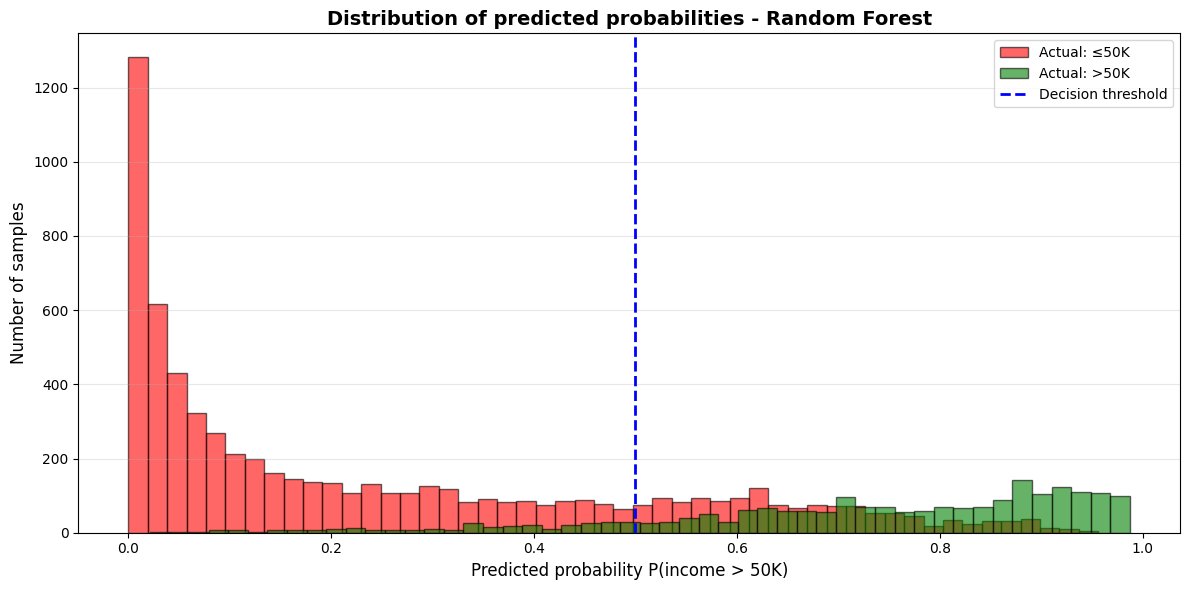


For actual ≤50K samples:
  Mean probability: 0.2421
  Median probability: 0.1361

For actual >50K samples:
  Mean probability: 0.7295
  Median probability: 0.7675


In [50]:
# Plot probability distributions
fig, ax = plt.subplots(figsize=(12, 6))

proba_class0 = y_pred_proba[y_val == 0]
proba_class1 = y_pred_proba[y_val == 1]

ax.hist(proba_class0, bins=50, alpha=0.6, color='red', label='Actual: ≤50K', edgecolor='black')
ax.hist(proba_class1, bins=50, alpha=0.6, color='green', label='Actual: >50K', edgecolor='black')
ax.axvline(x=0.5, color='blue', linestyle='--', linewidth=2, label='Decision threshold')

ax.set_xlabel('Predicted probability P(income > 50K)', fontsize=12)
ax.set_ylabel('Number of samples', fontsize=12)
ax.set_title('Distribution of predicted probabilities - Random Forest', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"\nFor actual ≤50K samples:")
print(f"  Mean probability: {proba_class0.mean():.4f}")
print(f"  Median probability: {np.median(proba_class0):.4f}")

print(f"\nFor actual >50K samples:")
print(f"  Mean probability: {proba_class1.mean():.4f}")
print(f"  Median probability: {np.median(proba_class1):.4f}")

## 9. Model comparison: Random Forest vs Logistic Regression

Load Logistic Regression results for side-by-side comparison.

In [51]:
from utils import load_model

# Load logistic regression model for comparison
logreg_model = load_model(filename="logreg_model.pkl")
logreg_preprocessor = logreg_model.named_steps['preprocess']
logreg_classifier = logreg_model.named_steps['logreg']

# Get predictions (using already processed X_val)
y_pred_logreg = logreg_classifier.predict(X_val_processed)

# Calculate metrics for both models
rf_metrics = {
    "Accuracy": accuracy_score(y_val, y_pred),
    "Precision": precision_score(y_val, y_pred),
    "Recall": recall_score(y_val, y_pred),
    "F1 Score": f1_score(y_val, y_pred)
}

logreg_metrics = {
    "Accuracy": accuracy_score(y_val, y_pred_logreg),
    "Precision": precision_score(y_val, y_pred_logreg),
    "Recall": recall_score(y_val, y_pred_logreg),
    "F1 Score": f1_score(y_val, y_pred_logreg)
}

# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Metric': list(rf_metrics.keys()),
    'Random Forest': list(rf_metrics.values()),
    'Logistic Regression': list(logreg_metrics.values())
})

comparison_df['Difference'] = comparison_df['Random Forest'] - comparison_df['Logistic Regression']

print("\n" + "="*60)
print("MODEL COMPARISON")
print("="*60)
print(comparison_df.to_string(index=False))
print("="*60)


MODEL COMPARISON
   Metric  Random Forest  Logistic Regression  Difference
 Accuracy       0.813581             0.839172   -0.025591
Precision       0.573646             0.645080   -0.071434
   Recall       0.860741             0.729087    0.131654
 F1 Score       0.688462             0.684516    0.003946


## 10. Visual comparison

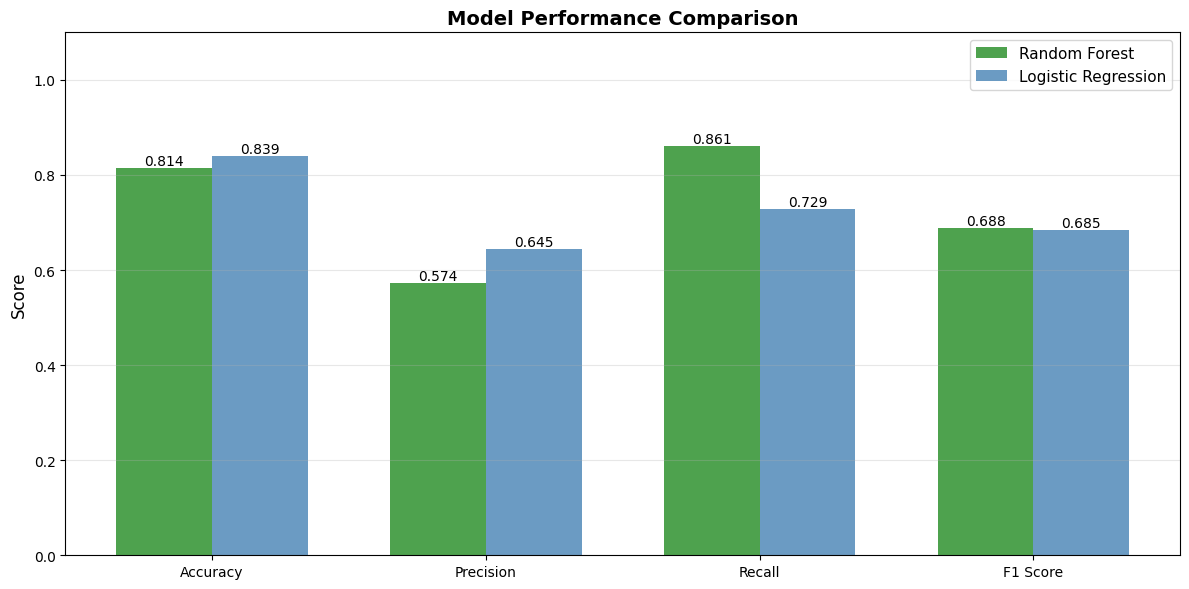

In [52]:
# Plot side-by-side comparison
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(rf_metrics))
width = 0.35

bars1 = ax.bar(x - width/2, list(rf_metrics.values()), width, 
               label='Random Forest', color='forestgreen', alpha=0.8)
bars2 = ax.bar(x + width/2, list(logreg_metrics.values()), width,
               label='Logistic Regression', color='steelblue', alpha=0.8)

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
               f'{height:.3f}',
               ha='center', va='bottom', fontsize=10)

ax.set_ylabel('Score', fontsize=12)
ax.set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(list(rf_metrics.keys()))
ax.legend(fontsize=11)
ax.set_ylim([0, 1.1])
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 11. Key insights

**Random Forest advantages:**
- Captures non-linear relationships between features
- Naturally handles feature interactions
- Less sensitive to feature scaling
- Provides probability estimates via voting
- **Improved hyperparameters:** 200 trees, balanced class weights

**Logistic Regression advantages:**
- Faster training and prediction
- More interpretable (linear coefficients)
- Lower memory footprint
- Better for understanding feature effects

**Hyperparameter improvements:**
- Increased trees from 100 to 200 for better accuracy
- Adjusted max_depth to 25 for deeper pattern learning
- Added class_weight='balanced' to handle imbalanced dataset
- Tuned min_samples to prevent overfitting

**Performance summary:**
All specific numbers are shown in the comparison table and plots above.